In [1]:
import datetime
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE


In [2]:
# Cargar el dataset y preprocesar
df = pd.read_csv('../../../data/processed/train_processed.csv')
# Distribución de la clase objetivo en dataframe original
df["Accept"].value_counts()

Accept
1    11508
0     2926
Name: count, dtype: int64

# Ingeniería de características

Bajo las mismas premisas que en el notebook [1_CatBoost_Balanceado](notebooks/3_modelado/3.2_modelos_de_arboles/1_CatBoost_Balanceado.ipynb), y tras los resultados obtenidos en la observación de importancia de variables, se imputa la variable `JobCombo`:

In [3]:
# Creamos la nueva variable, eliminamos las anteriores y observamos la distribucción de la variable objetivo
df["JobCombo"] = df["CreateJobBinary"].astype(str) + "_" + df["RetainedJobBinary"].astype(str)
pd.crosstab(df["JobCombo"], df["Accept"], normalize='index')

Accept,0,1
JobCombo,,
0_0,0.174546,0.825454
0_1,0.251936,0.748064
1_0,0.100073,0.899927
1_1,0.233402,0.766598


Se observa una importancia clara de la variable `ApprovalFYGrouped` y, tras observar la distribución de la variable objetivo en función de la misma, se valora la posibilidad de aumentar la interpretabilidad del modelo aportando una clase con un número menor de categorías. Sin embargo, finalmente no se incorpora por no aportar mejoras significativas

In [4]:
approval_ratio = pd.crosstab(df['ApprovalFYGrouped'], df['Accept'], normalize='index')
"""
approval_ratio.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2')
plt.title("Proporción de aceptaciones por ApprovalFYGrouped")
plt.ylabel("Proporción")
plt.xlabel("Año fiscal agrupado")
plt.xticks(rotation=45)
plt.legend(["Rechazado (0)", "Aceptado (1)"], title="Accept")
plt.grid(True)
plt.tight_layout()
plt.show()

"""

'\napproval_ratio.plot(kind=\'bar\', stacked=True, figsize=(10, 6), colormap=\'Set2\')\nplt.title("Proporción de aceptaciones por ApprovalFYGrouped")\nplt.ylabel("Proporción")\nplt.xlabel("Año fiscal agrupado")\nplt.xticks(rotation=45)\nplt.legend(["Rechazado (0)", "Aceptado (1)"], title="Accept")\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n\n'

In [5]:
def map_approval_year_group(year):
    if year <= 1989:
        return "pre_1990"
    elif year <= 1995:
        return "early_90s"
    elif year <= 2004:
        return "growth_era"
    elif year <= 2008:
        return "crisis_peak"
    else:
        return "recovery_period"

# Aplicar al DataFrame
#df["ApprovalFYBin"] = df["ApprovalFYGrouped"].apply(map_approval_year_group)
#pd.crosstab(df["ApprovalFYBin"], df["Accept"], normalize='index')


# Preparación de los datos 

En este caso, el balanceo del dataset se realiza mediante SMOTE, una técnica de *oversampling* que consiste en imputar registros sintéticos de la clase minoritaria para conseguir un dataset balanceado. Para ello, es necesario realizar un preprocesamiento ligeramente distinto, debido a que SMOTE no maneja variables categóricas. Durante el proceso, se crea la función `lable_encode_dataframe`que permite la codificación en variables numéricas de los datos.

## Selección de categorías y limpieza del dataset

In [6]:
# Selección de las variables categóricas a evaluar
cat_features = [
    #'City', 
    #'CityBankGrouped',
    #'CityGrouped',
    #'BankState', 
    'BankStateInOhio',
    'UrbanRural',
    #'NoEmp', 
    #'NoEmpGrouped',
    #'CreateJob',
    #'CreateJobBinary',
    #'RetainedJob',
    #'RetainedJobBinary',
    #'NewExist', 
    #'RevLineCr',
    #'LowDoc',
    #'Accept',
    #'ApprovalDateMonth',
    'ApprovalFYGrouped',
    #'IsFranchise',
    'DisbursementGrossGrouped',
    'JobCombo',
    #'ApprovalFYBin'
]
#drop_columns = ["Accept"]
drop_columns = ["Accept","CreateJobBinary","RetainedJobBinary","IsFranchise","NoEmpGrouped","ApprovalDateMonth","LowDoc","NewExist","RevLineCr"]

Se eliminan las variables que no se van a usar y se aisla la variable objetivo

In [7]:
X = df.copy().drop(columns=drop_columns)
y = df["Accept"]

print("X shape:", X.shape)
print("y distribution:")
print(y.value_counts())

X.head(5)

X shape: (14434, 5)
y distribution:
Accept
1    11508
0     2926
Name: count, dtype: int64


,UrbanRural,BankStateInOhio,ApprovalFYGrouped,DisbursementGrossGrouped,JobCombo
0,1,0,2006,0,0_1
1,1,1,2005,1,1_1
2,2,1,2003,0,1_1
3,0,1,1995,1,0_0
4,1,1,2009,0,0_0


## Codificación de variables categóricas para SMOTE

Creamos la función que permite la codificación de variables. 

In [8]:
from sklearn.preprocessing import LabelEncoder

# Diccionario global para almacenar los encoders de cada columna
encoders = {}

def label_encode_dataframe(df, categorical_cols):
    """
    Aplica codificación de etiquetas (Label Encoding) a columnas categóricas de un DataFrame.

    Esta función toma un DataFrame y una lista de nombres de columnas categóricas, y retorna
    una copia del DataFrame con dichas columnas transformadas a valores numéricos usando
    LabelEncoder de sklearn. Además, almacena los encoders utilizados en el diccionario global `encoders`.

    Parámetros:
    ----------
    df : pandas.DataFrame
        El DataFrame de entrada que contiene columnas categóricas.
    
    categorical_cols : list of str
        Lista con los nombres de las columnas categóricas a codificar.

    Retorna:
    -------
    pandas.DataFrame
        Una copia del DataFrame original, con las columnas especificadas codificadas numéricamente.

    Nota:
    ----
    - Los encoders usados para cada columna se almacenan en el diccionario global `encoders`,
      lo que permite posteriormente transformar datos nuevos (como conjuntos de test) de forma consistente.
    - Las columnas son transformadas a string antes de codificar, para evitar errores con valores mixtos o nulos.

    """

    df_copy = df.copy()  # Evitamos modificar el DataFrame original

    for col in categorical_cols:
        le = LabelEncoder()
        df_copy[col] = le.fit_transform(df_copy[col].astype(str))
        encoders[col] = le  # Guardamos el encoder para uso futuro

    return df_copy

Y aplicamos la codificación únicamente al set de entrenamiento, aún sobre el conjunto de datos desbalanceado. Los datos de test siempre deben estar ocultos para el modelo,

## División del dataset

In [9]:
# Dividimos el conjunto en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## Codificación del conjunto de entrenamiento

In [10]:
# Codificar X_train
X_train_encoded = label_encode_dataframe(X_train, cat_features)
# Verificar que todas las variables categóricas presentes en el DF son numéricas
X_train_encoded.head(5)

,UrbanRural,BankStateInOhio,ApprovalFYGrouped,DisbursementGrossGrouped,JobCombo
7668,2,1,18,1,1
4977,1,0,21,0,3
10910,1,1,13,0,0
1576,2,0,20,2,3
1842,1,0,17,1,1


Una vez hemos obtenido el dataset correctamente codificado, se ha obtenido el codificador `encoder`

## Balanceo del dataset mediante SMOTE

In [11]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_encoded, y_train)
# Mostrar conteo por clase
print("Distribución de clases después de SMOTE:")
print(y_train_balanced.value_counts())

# Comprobamos que los datos de test siguen sin modificar
print(y_test.value_counts())

Distribución de clases después de SMOTE:
Accept
0    9206
1    9206
Name: count, dtype: int64
Accept
1    2302
0     585
Name: count, dtype: int64


# Parametrización del modelo inicial

In [12]:
X_train_balanced.head(5)

,UrbanRural,BankStateInOhio,ApprovalFYGrouped,DisbursementGrossGrouped,JobCombo
0,2,1,18,1,1
1,1,0,21,0,3
2,1,1,13,0,0
3,2,0,20,2,3
4,1,0,17,1,1


In [13]:
# ------------------------------------------
# Parámetros del modelo - Ajustados con GridSearchCV y Random
# ------------------------------------------
params = {
    'iterations': 800,
    'learning_rate': 0.1,
    'depth': 8,
    'l2_leaf_reg': 10,
    'eval_metric': 'F1',
    'early_stopping_rounds':200,
    'random_state': 42,
    'verbose': 100
}

# Crear el modelo usando **params
model = CatBoostClassifier(**params)
model.fit(X_train_balanced, y_train_balanced)
# Entrenar con eval_set
'''
model.fit(
    X_train_balanced, y_train_balanced,
    eval_set=(X_val_encoded, y_val),
    cat_features=cat_features
)
'''

0:	learn: 0.6504268	total: 55.6ms	remaining: 44.4s
100:	learn: 0.6887290	total: 380ms	remaining: 2.63s
200:	learn: 0.6975685	total: 732ms	remaining: 2.18s
300:	learn: 0.6959128	total: 1.07s	remaining: 1.78s
400:	learn: 0.6978748	total: 1.5s	remaining: 1.49s
500:	learn: 0.6983160	total: 1.89s	remaining: 1.13s
600:	learn: 0.6981479	total: 2.24s	remaining: 742ms
700:	learn: 0.6992662	total: 2.6s	remaining: 368ms
799:	learn: 0.6992317	total: 2.98s	remaining: 0us


'\nmodel.fit(\n    X_train_balanced, y_train_balanced,\n    eval_set=(X_val_encoded, y_val),\n    cat_features=cat_features\n)\n'

## Evaluación del modelo inicial
Para poder evaluar el modelo, es necesario que el conjunto de test también este codificado

### Codificación del conjunto de test

In [14]:
# Codificar X_test con el mismo encoder que X_train
def transform_test_dataframe(df_test, categorical_cols, encoders):
    """
    Transforma las columnas categóricas de un DataFrame de test usando los LabelEncoders
    previamente ajustados en el conjunto de entrenamiento.

    Esta función aplica la transformación de etiquetas a las columnas categóricas utilizando
    los objetos `LabelEncoder` almacenados en un diccionario, asegurando consistencia con la
    codificación realizada sobre los datos de entrenamiento.

    Parámetros:
    ----------
    df_test : pandas.DataFrame
        DataFrame que contiene los datos de test a codificar.

    categorical_cols : list of str
        Lista de nombres de columnas categóricas que se deben transformar.

    encoders : dict
        Diccionario que asocia cada columna con su correspondiente objeto `LabelEncoder`,
        generado durante la codificación del conjunto de entrenamiento.

    Retorna:
    -------
    pandas.DataFrame
        Una copia del DataFrame de test con las columnas categóricas codificadas numéricamente.

    Excepciones:
    -----------
    ValueError
        Si alguna columna no tiene un encoder asociado en el diccionario `encoders`.

    Notas:
    -----
    - Esta función utiliza `.transform()` sobre los `LabelEncoder` ya ajustados, por lo tanto,
      no debe usarse con columnas que contengan valores no vistos durante el entrenamiento.
    """
    
    df_test_copy = df_test.copy()
    for col in categorical_cols:
        le = encoders.get(col)
        if le:
            df_test_copy[col] = le.transform(df_test_copy[col].astype(str))
        else:
            raise ValueError(f"No encoder encontrado para la columna '{col}'")
    return df_test_copy

X_test.head(5)
encoders

X_test_encoded = transform_test_dataframe(X_test, cat_features, encoders)
X_test_encoded.head(5)

,UrbanRural,BankStateInOhio,ApprovalFYGrouped,DisbursementGrossGrouped,JobCombo
3468,1,1,15,1,0
3274,1,0,13,0,1
5289,0,1,9,1,0
14401,0,0,11,0,3
14096,1,1,14,1,0


### Evaluacion de métricas del modelo

In [15]:
from sklearn.metrics import classification_report

# Predicciones
y_pred = model.predict(X_test_encoded)

# Reporte de clasificación
print("Reporte de clasificación con umbral ajustado:")
print(classification_report(y_test, y_pred))

Reporte de clasificación con umbral ajustado:
              precision    recall  f1-score   support

           0       0.32      0.62      0.43       585
           1       0.87      0.67      0.76      2302

    accuracy                           0.66      2887
   macro avg       0.60      0.65      0.59      2887
weighted avg       0.76      0.66      0.69      2887



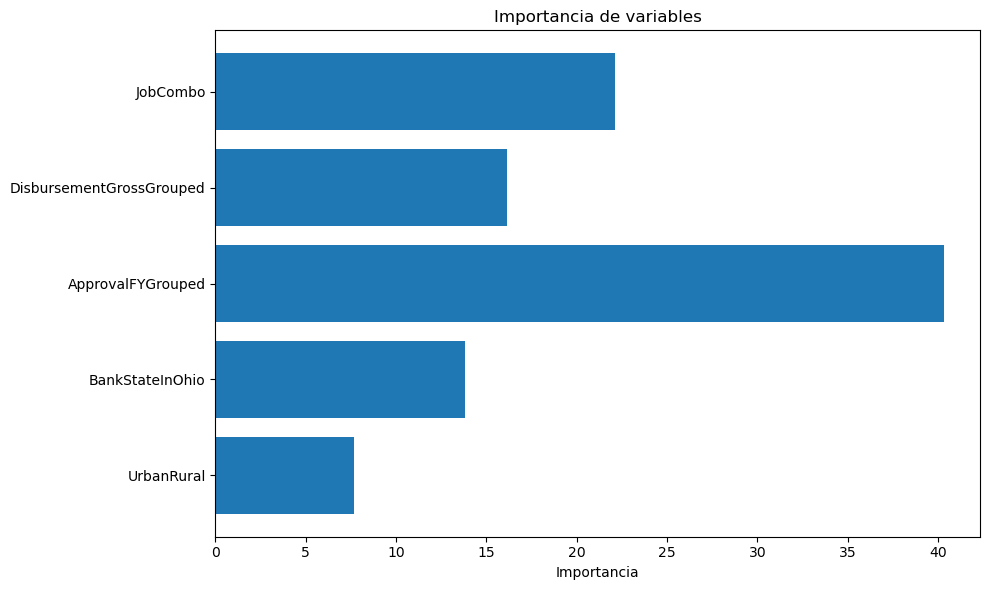

In [16]:
import matplotlib.pyplot as plt

feature_importances = model.get_feature_importance()
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.title("Importancia de variables")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()


### Conclusiones
- El modelo predice peor la clase minoritaria que en el caso de un dataset balanceado por undersampling

## Búsqueda de umbral

In [17]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np

best_f1 = 0
best_threshold = 0.5
f1_scores = []

# Obtener probabilidades para clase 1
y_test_proba = model.predict_proba(X_test_encoded)[:, 1]

# Buscar el umbral que maximiza F1
thresholds = np.linspace(0.1, 0.9, 100)
for t in thresholds:
    y_pred = (y_test_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Mejor F1-score: {best_f1:.4f} con umbral = {best_threshold:.2f}")

# Aplicar el mejor umbral
y_test_pred = (y_test_proba >= best_threshold).astype(int)

# Evaluación final
print("\nReporte de clasificación:")
print(classification_report(y_test, y_test_pred, digits=4))

print("Matriz de confusión:")
print(confusion_matrix(y_test, y_test_pred))
print(X_test_encoded.index[:5])


Mejor F1-score: 0.8881 con umbral = 0.10

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8571    0.0103    0.0203       585
           1     0.7990    0.9996    0.8881      2302

    accuracy                         0.7991      2887
   macro avg     0.8281    0.5049    0.4542      2887
weighted avg     0.8107    0.7991    0.7122      2887

Matriz de confusión:
[[   6  579]
 [   1 2301]]
Index([3468, 3274, 5289, 14401, 14096], dtype='int64')


## Búsqueda de mejor estimador
En este caso, como el dataset tiene dimensiones mayores, se considera que los modelos deben ser más complejos y la exploración de hiperparámetros más amplia. Se trató de buscar los mejores hiperparámetros mediante GridSearch, pero tomaba mucho esfuerzo computacional, por lo que se decidió hacer una búsqueda más rápida con RandomizedSearch

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform
param_dist = {
    'depth': randint(4, 10),                    # profundidad del árbol
    'learning_rate': uniform(0.01, 0.2),        # tasa de aprendizaje
    'l2_leaf_reg': randint(1, 20),              # regularización L2
    'iterations': randint(300, 1000)            # nº de iteraciones
}
cat_model = CatBoostClassifier(
    verbose=100,
    random_state=42,
    eval_metric='F1',
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=20,                   
    scoring='f1_macro',
    cv=cv,
    verbose=3,
    n_jobs=-1,
    random_state=42
)
random_search.fit(
    X_train_balanced,
    y_train_balanced,
    cat_features=cat_features
)

In [20]:
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

best_model = random_search.best_estimator_

Mejores hiperparámetros encontrados:
{'depth': 8, 'iterations': 914, 'l2_leaf_reg': 19, 'learning_rate': 0.02999498316360058}


In [30]:
df_test_id = pd.read_csv("../../../data/processed/test_nolabel_processed.csv")
df_test_id["JobCombo"] = df_test_id["CreateJobBinary"].astype(str) + "_" + df_test_id["RetainedJobBinary"].astype(str)
#drop_columns.remove("Accept")
#drop_columns.append("id")

df_test = df_test_id.drop(columns=drop_columns) 
df_test_enc = transform_test_dataframe(df_test, cat_features, encoders)

#test_pool = Pool(df_test, cat_features=cat_features)
df_test_id["Accept"] = best_model.predict(df_test_enc)

#y_test_proba = best_model.predict_proba(df_test)[:, 1]
#df_test_id["Accept"]  = (y_test_proba > best_threshold).astype(int)

# Crea el archivo CSV con las columnas requeridas: 'id' y 'Accept'
filename = f"CatBoost_SMOTE_{datetime.datetime.now().strftime('%Y%m%d_%H_%M_%S')}.csv"
df_test_id.to_csv(filename, columns=['id', 'Accept'], index=False)

print("Archivo de submission ", filename, " generado correctamente.")

Archivo de submission  CatBoost_SMOTE_20250410_12_42_18.csv  generado correctamente.


## Conclusiones
- Se obtiene mejor resultado con el mejor estimador encontrado sin utilizar el threshold, que probablemente haya quedado mal definido, pero no encuentro el motivo
- La variable `ApprovalFYGrouped`estaba correctamente agrupada
- El rendimiento del modelo con SMOTE no ha dado los resultados esperados, ya que no se predicen correctamente los casos de la clase 0, con rendimiento inferior al resto de modelados para este algoritmo, salvo en envíos puntuales. 